## Dependencias 

In [57]:
import numpy as np 
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from functools import reduce 
pd.set_option('display.max_columns',None)

## Lectura de datos 

In [4]:
data = pd.read_csv('../data/heart_disease.tab',delimiter='\t')
data.shape

(303, 14)

In [9]:

data.sample(5)

,diameter narrowing,age,gender,chest pain,rest SBP,cholesterol,fasting blood sugar > 120,rest ECG,max HR,exerc ind ang,ST by exercise,slope peak exc ST,major vessels colored,thal
0,0,63,male,typical ang,145,233,1,left vent hypertrophy,150,0,2.3,downsloping,0.0,fixed defect
55,1,54,male,asymptomatic,124,266,0,left vent hypertrophy,109,1,2.2,flat,1.0,reversable defect
288,0,56,male,atypical ang,130,221,0,left vent hypertrophy,163,0,0.0,upsloping,0.0,reversable defect
174,1,64,male,asymptomatic,145,212,0,left vent hypertrophy,132,0,2.0,flat,2.0,fixed defect
261,1,58,female,atypical ang,136,319,1,left vent hypertrophy,152,0,0.0,upsloping,2.0,normal


## Clasificación de variables 

In [10]:
varc = ['age','rest SBP','cholesterol','max HR','ST by exercise','major vessels colored']
vard = [ 'gender', 'chest pain',  'fasting blood sugar > 120', 'rest ECG', 'exerc ind ang',  'slope peak exc ST','thal']
vart = ['diameter narrowing']

## Partición 

In [14]:
train,valid = train_test_split(data,test_size=0.2)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((242, 14), (61, 14))

### Matriz de predictoras $\mathcal{X}$

In [18]:
oh = OneHotEncoder(drop='if_binary',sparse_output=False)
oh.fit(train[vard])
varoh = list(oh.get_feature_names_out())
varoh

['gender_male',
 'chest pain_asymptomatic',
 'chest pain_atypical ang',
 'chest pain_non-anginal',
 'chest pain_typical ang',
 'fasting blood sugar > 120_1',
 'rest ECG_ST-T abnormal',
 'rest ECG_left vent hypertrophy',
 'rest ECG_normal',
 'exerc ind ang_1',
 'slope peak exc ST_downsloping',
 'slope peak exc ST_flat',
 'slope peak exc ST_upsloping',
 'thal_fixed defect',
 'thal_normal',
 'thal_reversable defect',
 'thal_nan']

In [ ]:
X = train[varc].copy()
X[varoh] = oh.transform(train[vard])
X.head()
im = SimpleImputer(strategy='median')
im.fit(X)
X = pd.DataFrame(im.transform(X),columns=X.columns)

,age,rest SBP,cholesterol,max HR,ST by exercise,major vessels colored,gender_male,chest pain_asymptomatic,chest pain_atypical ang,chest pain_non-anginal,chest pain_typical ang,fasting blood sugar > 120_1,rest ECG_ST-T abnormal,rest ECG_left vent hypertrophy,rest ECG_normal,exerc ind ang_1,slope peak exc ST_downsloping,slope peak exc ST_flat,slope peak exc ST_upsloping,thal_fixed defect,thal_normal,thal_reversable defect,thal_nan
0,65,140,417,157,0.8,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,41,112,250,179,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,59,110,239,142,1.2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,55,132,342,166,1.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,61,148,203,161,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Vector respuesta $\vec{y}$

In [24]:
y = train[vart[0]]
y.head()

0    0
1    0
2    1
3    0
4    1
Name: diameter narrowing, dtype: int64

## Aprendizaje 

In [30]:
var = varc+varoh

### Predictoras más fuertes 

In [31]:
sk = SelectKBest(k=len(var))
sk.fit(X,y)

,score_func,<function f_c...t 0x119507920>
,k,23


<Axes: >

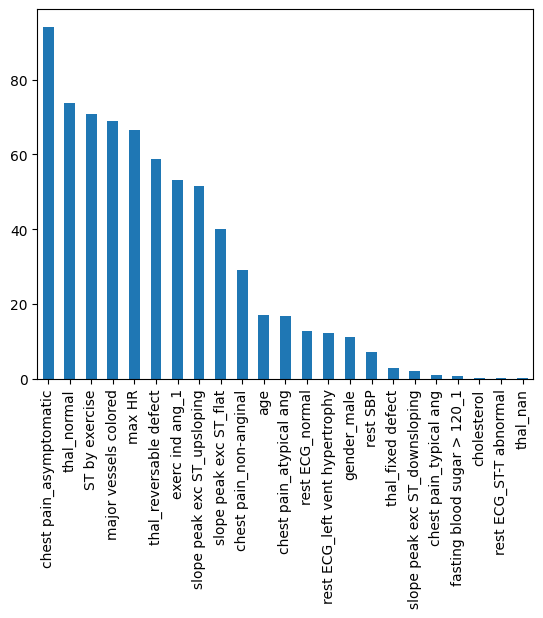

In [35]:
pd.Series(dict(zip(var,sk.scores_))).sort_values(ascending=False).plot(kind='bar')

In [36]:
k = 5 
sk = SelectKBest(k=k)
sk.fit(X,y)

,score_func,<function f_c...t 0x119507920>
,k,5


In [38]:
best = [v for v,s in zip(var,sk.get_support()) if s]
best

['max HR',
 'ST by exercise',
 'major vessels colored',
 'chest pain_asymptomatic',
 'thal_normal']

In [41]:
X = train[varc].copy()
X[varoh] = oh.transform(train[vard])
X.head()
im = SimpleImputer(strategy='median')
im.fit(X[best])
X = pd.DataFrame(im.transform(X[best]),columns=best)

### Híper-parametrización

In [43]:
hparam_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(2,6),
    'min_samples_split': np.arange(0.05,0.1,0.01),
    'min_samples_leaf': np.arange(0.05,0.1,0.01),
    'min_weight_fraction_leaf': np.arange(0.05,0.1,0.01),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': range(2,11)
}


In [45]:
reduce(lambda x,y: x*y, map(len,hparam_grid.values()))

54000

In [46]:
dt = DecisionTreeClassifier()

In [47]:
grid = GridSearchCV(
    estimator=dt,
    param_grid=hparam_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

In [49]:
grid.fit(X,y)

/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
90000 fits failed out of a total of 270000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45786 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/p

,estimator,DecisionTreeClassifier()
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': range(2, 6), 'max_features': ['auto', 'sqrt', ...], 'max_leaf_nodes': range(2, 11), ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


In [50]:
grid.best_score_

np.float64(0.8982382212144117)

In [52]:
dt = grid.best_estimator_

### Aprendizaje final $\vec{y} = f (\mathcal{X};\theta)$  (Ahora si vamos a aprender el modelo)

In [54]:
dt.fit(X,y)

,criterion,'entropy'
,splitter,'best'
,max_depth,5
,min_samples_split,np.float64(0.05)
,min_samples_leaf,np.float64(0.05)
,min_weight_fraction_leaf,np.float64(0....0000000000005)
,max_features,'sqrt'
,random_state,None
,max_leaf_nodes,9
,min_impurity_decrease,0.0
,class_weight,None


## Generalización del modelo (qué tan bien se comporta en datos que nunca vió, es importante aplicar TODAS las transfromaciones previas)

In [70]:
Xv = valid[varc].copy()
Xv[varoh] = oh.transform(valid[vard])
Xv = pd.DataFrame(im.transform(Xv[best]),columns=best)

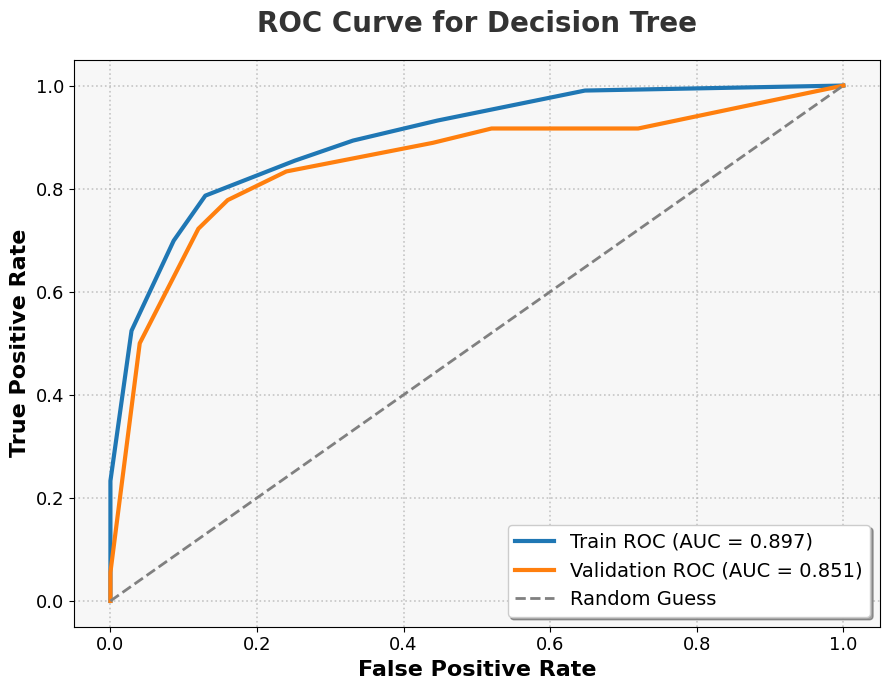

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Training ROC and AUC
y_train_proba = dt.predict_proba(X)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y, y_train_proba)
auc_train = auc(fpr_train, tpr_train)

# Validation ROC and AUC
y_valid = valid['diameter narrowing']
y_valid_proba = dt.predict_proba(Xv)[:, 1]
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
auc_valid = auc(fpr_valid, tpr_valid)

plt.figure(figsize=(9, 7))
plt.plot(fpr_train, tpr_train, color='#1f77b4', lw=3, label=f'Train ROC (AUC = {auc_train:.3f})')
plt.plot(fpr_valid, tpr_valid, color='#ff7f0e', lw=3, label=f'Validation ROC (AUC = {auc_valid:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')

plt.title('ROC Curve for Decision Tree', fontsize=20, fontweight='bold', color='#333333', pad=20)
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.legend(fontsize=14, loc='lower right', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', linewidth=1.2, alpha=0.7)
plt.gca().set_facecolor('#f7f7f7')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
plt.show()

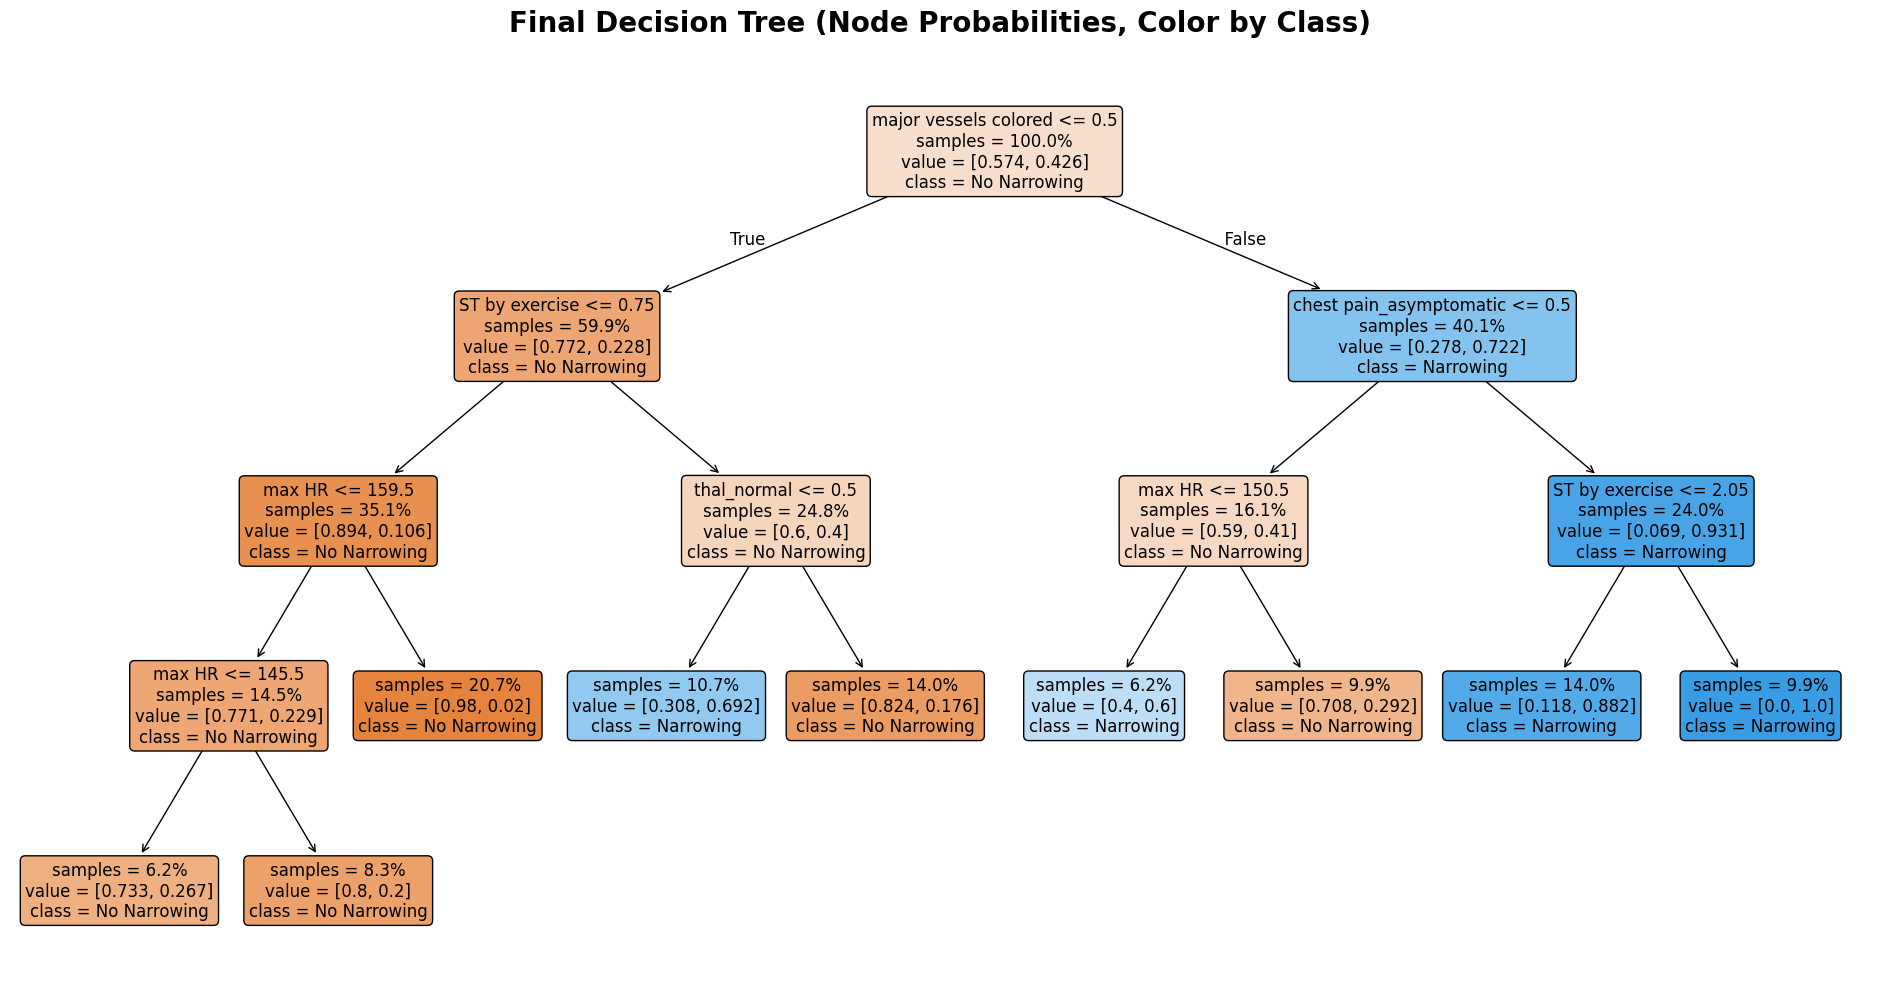

In [73]:

plt.figure(figsize=(24, 12))
plot_tree(
    dt,
    feature_names=best,
    class_names=['No Narrowing', 'Narrowing'],
    filled=True,
    rounded=True,
    proportion=True,
    impurity=False,
    precision=3,
    fontsize=12,
    label='all'
)
plt.title("Final Decision Tree (Node Probabilities, Color by Class)", fontsize=20, fontweight='bold', pad=20)
plt.show()


## Uso del modelo 

In [74]:


train_node_ids = dt.apply(X)
valid_node_ids = dt.apply(Xv)

# Build DataFrames for train and valid
df_train_nodes = pd.DataFrame({
    'target': y.values,
    'node': train_node_ids,
    'sample': 'train'
})

df_valid_nodes = pd.DataFrame({
    'target': y_valid.values,
    'node': valid_node_ids,
    'sample': 'valid'
})

# Concatenate into a single DataFrame
df_nodes = pd.concat([df_train_nodes, df_valid_nodes], ignore_index=True)

# Show the first few rows
df_nodes.head()


,target,node,sample
0,0,14,train
1,0,10,train
2,1,11,train
3,0,8,train
4,1,11,train


In [80]:
df_nodes.assign(n=1).groupby(list(df_nodes.columns)).count().to_clipboard()